In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split

Load Data & Explore

In [3]:
# Load data
train_df = pd.read_csv('/content/drive/MyDrive/code/convolutions-for-toxic-text-classification/train.csv').fillna(" ")
train_df.sample (10, random_state=1)

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


Toxic Comments

In [4]:
train_df.loc[train_df['toxic']==1].sample(10, random_state=10)

,comment_text,toxic
30575,"""\n Are you asking if we would ever block some...",1
36038,Amen my sock-pupinski brother!! Hack-a-long: p...,1
19730,JUST READ THE FUCKING CENSUS DATA. Do you thin...,1
72261,u no wat ass hole go fuck your self and stop b...,1
77923,Go fuck yourself \n\nEat shit and die. 68.0.11...,1
16382,A big thank you\n\nYou have just blocked me in...,1
41247,A message from Jasonceyre \n\n f uc k you ho...,1
69311,"I'm gonna get the ACLU on you, you racist anti...",1
142032,"Hey Freepsbane, does your mother know that you...",1
5613,You guys suk. You really really suck. Fuck you...,1


Word Cloud

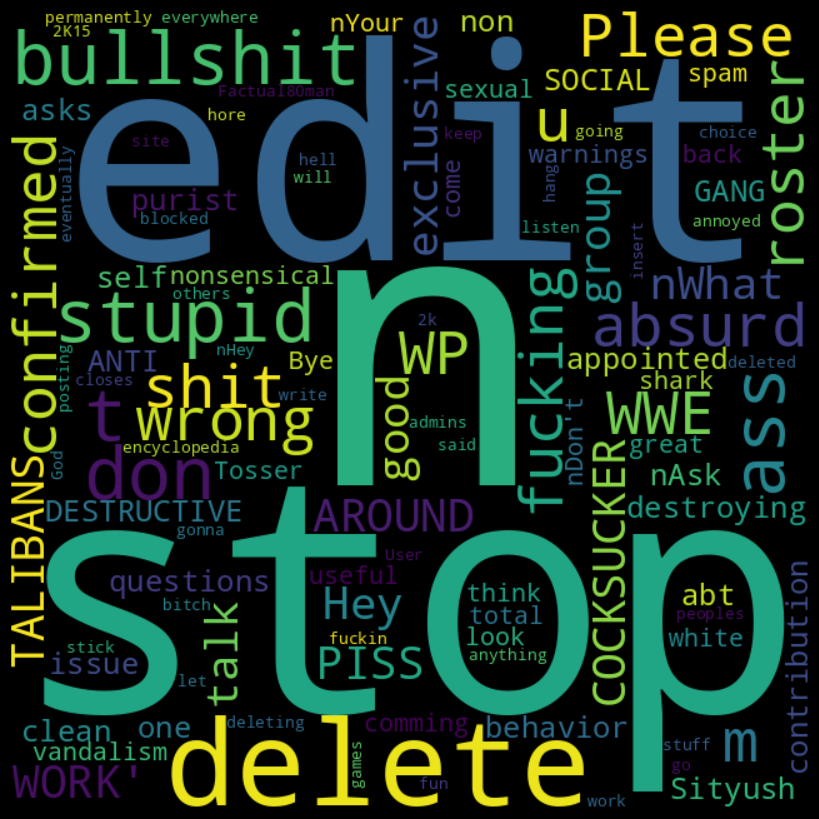

In [5]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [6]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


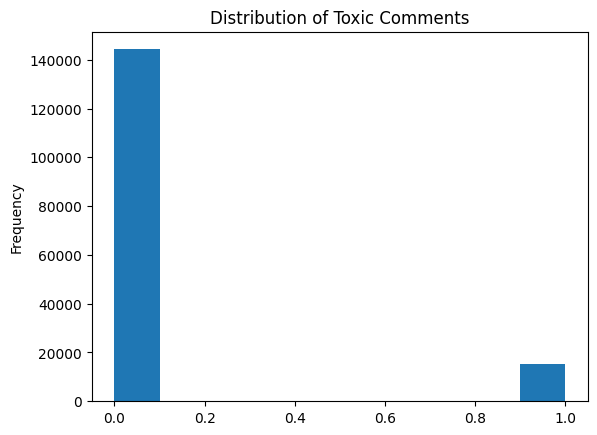

In [7]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist', title='Distribution of Toxic Comments');

In [8]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

Data Prep: Tokenize & Pad  

In [9]:
max_features = 20000
max_text_length = 400

In [11]:
x = train_df['comment_text'].values

In [15]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list (x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences (x_tokenized, maxlen=max_text_length)

Download Pre-trained GloVe Embeddings & Embed Matrix with

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [18]:
embedding_dim = 100
embeddings_index = dict()
f = open('/content/drive/MyDrive/code/convolutions-for-toxic-text-classification/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values [1:], dtype='float32')
    embeddings_index[word] = coefs
f.close ()

Create Embedding Layer


In [20]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items ():
    if index > max_features -1:
        break
    else:
        embedding_vector = embeddings_index.get (word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Create Model

In [23]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [25]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(
                        embedding_matrix),
                    trainable=False))
model.add (Dropout (0.2))
model.add(Conv1D(filters,
    kernel_size, padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
            5,
            padding='valid',
            activation='relu'))
model.add(GlobalMaxPooling1D ())
model.add (Dense(hidden_dims, activation='relu' ))
model.add (Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary ()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         2000000   
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 250)         75250     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 250)         0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, None, 250)         312750    
                                                                 
 global_max_pooling1d (Glob  (None, 250)               0         
 alMaxPooling1D)                                      

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

Prepare Data Split

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y,
    test_size=0.15, random_state=1)

Train Model

In [30]:
%%time
batch_size = 32
epochs = 3
model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=3,
    validation_data=(x_val, y_val))

Epoch 1/3
4239/4239 [==============================] - 51s 9ms/step - loss: 0.1546 - accuracy: 0.9442 - val_loss: 0.1413 - val_accuracy: 0.9515
Epoch 2/3
4239/4239 [==============================] - 39s 9ms/step - loss: 0.1329 - accuracy: 0.9511 - val_loss: 0.1229 - val_accuracy: 0.9533
Epoch 3/3
4239/4239 [==============================] - 39s 9ms/step - loss: 0.1253 - accuracy: 0.9534 - val_loss: 0.1175 - val_accuracy: 0.9563
CPU times: user 1min 46s, sys: 5.78 s, total: 1min 52s
Wall time: 2min 24s


Evaluate on Test Set

In [31]:
test_df = pd.read_csv('/content/drive/MyDrive/code/convolutions-for-toxic-text-classification/test.csv')
x_test = test_df ['comment_text'].values
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [32]:
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in y_testing]
test_df [[' comment text', "Toxic"]].head(20) #. sample (20, random state=1)

NameError: ignored